# Import

In [ ]:
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 21.9 MB/s eta 0:00:00


In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import comb
from tabulate import tabulate
import plotly.graph_objs as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from datetime import datetime

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')


# Stock Loading

In [ ]:
stock = 'AAPL'
stock_data = yf.download(stock, start="2023-03-28", end="2024-04-01")
stock_data.dropna(inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2023-03-28 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


# Visualization/Analysis of Stock

In [ ]:
# Fetching data from Yahoo Finance
aaple_data = yf.download('AAPL')
prev_start = datetime.today() - pd.DateOffset(years=1)
prev_end = datetime.today()
# Creating Dash app
app = dash.Dash(__name__)

# External CSS styles
external_stylesheets = ['https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

# Layout of the dashboard
app.layout = html.Div([
    html.Div(className='container-fluid', children=[
        html.H1("Apple Stock Dashboard", className='text-center mt-4 mb-4'),

        # Top row with styled boxes for required information
        html.Div(className='row justify-content-center', children=[
            html.Div(className='col-md-3 text-center', children=[
                html.Div(className='card bg-light', children=[
                    html.Div(className='card-body', children=[
                        html.H5("Today's Price", className='card-title'),
                        html.H4("${:.2f}".format(aaple_data['Close'][-1]), className='card-text')
                    ])
                ])
            ]),
            html.Div(className='col-md-3 text-center', children=[
                html.Div(className='card bg-light', children=[
                    html.Div(className='card-body', children=[
                        html.H5("Percentage Change", className='card-title'),
                        html.H4("{:.2f}%".format((aaple_data['Close'][-1] - aaple_data['Close'][-2]) / aaple_data['Close'][-2] * 100), className='card-text', style={'color': 'red' if (aaple_data['Close'][-1] - aaple_data['Close'][-2]) / aaple_data['Close'][-2] < 0 else 'green'})
                    ])
                ])
            ]),
            html.Div(className='col-md-3 text-center', children=[
                html.Div(className='card bg-light', children=[
                    html.Div(className='card-body', children=[
                        html.H5("Opening Price", className='card-title'),
                        html.H4("${:.2f}".format(aaple_data['Open'][-1]), className='card-text')
                    ])
                ])
            ]),
            html.Div(className='col-md-3 text-center', children=[
                html.Div(className='card bg-light', children=[
                    html.Div(className='card-body', children=[
                        html.H5("Previous Close", className='card-title'),
                        html.H4("${:.2f}".format(aaple_data['Close'][-2]), className='card-text')
                    ])
                ])
            ])
        ]),
        html.Br(),

        # Buttons for selecting predefined time ranges and dropdown for selecting plot type
        html.Div(className='row justify-content-center mt-2', children=[
            html.Div(className='col-md-4 text-center', children=[
                dcc.DatePickerRange(
                    id='date-range-picker',
                    display_format='YYYY-MM-DD',
                    start_date_placeholder_text='Start Date',
                    end_date_placeholder_text='End Date',
                    className='mr-2'
                ),
            ]) ,

            html.Button('1m', id='btn-1m', n_clicks=0, className='btn btn-primary mr-2'),
            html.Button('3m', id='btn-3m', n_clicks=0, className='btn btn-primary mr-2'),
            html.Button('6m', id='btn-6m', n_clicks=0, className='btn btn-primary mr-2'),
            html.Button('1y', id='btn-1y', n_clicks=0, className='btn btn-primary mr-2'),
            html.Button('2y', id='btn-2y', n_clicks=0, className='btn btn-primary mr-2'),
            html.Button('5y', id='btn-5y', n_clicks=0, className='btn btn-primary mr-2'),
            html.Button('Max', id='btn-max', n_clicks=0, className='btn btn-primary mr-2') ,
            html.Div(className='col-md-4 text-center', children=[
                dcc.Dropdown(
                    id='plot-type-dropdown',
                    options=[
                        {'label': 'Line Chart', 'value': 'line'},
                        {'label': 'Area Chart', 'value': 'area'},
                        {'label': 'Candlestick Chart', 'value': 'candlestick'}
                    ],
                    value='line',
                    className='dropdown'
                )
            ])
        ]),
        html.Br(),

        # Checkboxes for selecting technical indicators
        html.Div(className='row justify-content-center mt-2', children=[
            html.Div(className='col-md-4 text-center', children=[
                html.Label('Technical Indicators:', style={'margin-right': '10px'}),
                dcc.Checklist(
                    id='technical-indicators-checkboxes',
                    options=[
                        {'label': 'Moving Average', 'value': 'moving-average'},
                        {'label': 'Bollinger Bands', 'value': 'bollinger-bands'}
                    ],
                    value=[],
                    labelStyle={'display': 'inline-block', 'margin-right': '20px'}
                )
            ])
        ]),

        # Stock plot
        html.Div(className='row justify-content-center', children=[
            html.Div(className='col-md-8', children=[
                dcc.Graph(
                    id='stock-plot'
                )
            ])
        ])
    ])
])

# Callback to update the plot based on the selected time range, plot type, moving average inclusion, and Bollinger Bands inclusion
@app.callback(
    Output('stock-plot', 'figure'),
    [Input('btn-1m', 'n_clicks'),
     Input('btn-3m', 'n_clicks'),
     Input('btn-6m', 'n_clicks'),
     Input('btn-1y', 'n_clicks'),
     Input('btn-2y', 'n_clicks'),
     Input('btn-5y', 'n_clicks'),
     Input('btn-max', 'n_clicks'),
     Input('date-range-picker', 'start_date'),
     Input('date-range-picker', 'end_date'),
     Input('plot-type-dropdown', 'value'),
     Input('technical-indicators-checkboxes', 'value')]
)
def update_stock_plot(btn_1m, btn_3m, btn_6m, btn_1y, btn_2y, btn_5y, btn_max, start_date, end_date, plot_type, technical_indicators):
    global prev_start, prev_end
    ctx = dash.callback_context
    changed_id = ctx.triggered[0]['prop_id'] if ctx.triggered else None

    if changed_id and 'btn-' in changed_id:
        if 'btn-1m' in changed_id:
            start_date = datetime.today() - pd.DateOffset(months=1)
        elif 'btn-3m' in changed_id:
            start_date = datetime.today() - pd.DateOffset(months=3)
        elif 'btn-6m' in changed_id:
            start_date = datetime.today() - pd.DateOffset(months=6)
        elif 'btn-1y' in changed_id:
            start_date = datetime.today() - pd.DateOffset(years=1)
        elif 'btn-2y' in changed_id:
            start_date = datetime.today() - pd.DateOffset(years=2)
        elif 'btn-5y' in changed_id:
            start_date = datetime.today() - pd.DateOffset(years=5)
        elif 'btn-max' in changed_id:
            start_date = aaple_data.index.min() + pd.DateOffset(days = 100 )
        else:
            start_date = datetime.today() - pd.DateOffset(years=5)
        end_date = datetime.today()
    elif changed_id and 'date-range-picker' in changed_id:
        if start_date is None or end_date is None:
            return dash.no_update
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    else:
        start_date = prev_start
        end_date = prev_end




    prev_start = start_date
    prev_end = end_date
    filtered_data = aaple_data[start_date :end_date ]
    l = len(filtered_data)
    # print(l)
    closing_prices = list(aaple_data['Close'])[-l-50 : ]
    ma = []
    std = []
    for i in range( 0 , len(closing_prices) - 50 ):
        ma.append(sum(closing_prices[i:i+50])/50)
        h = np.array(closing_prices[i:i+50])
        std.append( h.std() )
    ma = np.array(ma)
    std = np.array(std)
    # print(len(closing_prices) , len(ma) , len(std))
    # print("OK" )
    # print()
    traces = []

    if plot_type == 'line':
        trace = go.Scatter(
            x=filtered_data.index,
            y=filtered_data['Close'],
            mode='lines',
            name='Price',
            showlegend= True ,
            hoverinfo='x+y+text',
            text=[f"Open: {o}<br>High: {h}<br>Low: {l}<br>Close: {c}"
                  for o, h, l, c in zip(filtered_data['Open'],
                                         filtered_data['High'],
                                         filtered_data['Low'],
                                         filtered_data['Close'])]
        )
        traces.append(trace)
    elif plot_type == 'area':
        trace = go.Scatter(
            x=filtered_data.index,
            y=filtered_data['Close'],
            fill='tozeroy',
            mode='none',
            name='Price',
            showlegend= True ,
            hoverinfo='x+y+text',
            text=[f"Open: {o}<br>High: {h}<br>Low: {l}<br>Close: {c}"
                  for o, h, l, c in zip(filtered_data['Open'],
                                         filtered_data['High'],
                                         filtered_data['Low'],
                                         filtered_data['Close'])]
        )
        traces.append(trace)
    elif plot_type == 'candlestick':
        trace = go.Candlestick(
            x=filtered_data.index,
            open=filtered_data['Open'],
            high=filtered_data['High'],
            low=filtered_data['Low'],
            close=filtered_data['Close'],
            name='Price',
            showlegend= True ,
            hoverinfo='x+text',
            text=[f"Open: {o}<br>High: {h}<br>Low: {l}<br>Close: {c}"
                  for o, h, l, c in zip(filtered_data['Open'],
                                         filtered_data['High'],
                                         filtered_data['Low'],
                                         filtered_data['Close'])]
        )
        traces.append(trace)


    if 'moving-average' in technical_indicators:
        # ma = filtered_data['Close'].rolling(window=50).mean()
        trace_ma = go.Scatter(
            x=filtered_data.index,
            y=ma,
            mode='lines',
            name='Moving Average (50)',
            hoverinfo='skip'
        )
        traces.append(trace_ma)

    if 'bollinger-bands' in technical_indicators:
        # ma = filtered_data['Close'].rolling(window=50).mean()
        # std = filtered_data['Close'].rolling(window=50).std()
        upper_band = ma + 2 * std
        lower_band = ma - 2 * std
        trace_upper_band = go.Scatter(
            x=filtered_data.index,
            y=upper_band,
            mode='lines',
            name='Upper Bollinger Band',
            hoverinfo='skip'
        )
        trace_lower_band = go.Scatter(
            x=filtered_data.index,
            y=lower_band,
            mode='lines',
            name='Lower Bollinger Band',
            hoverinfo='skip'
        )
        trace_upper_fill = go.Scatter(
            x=filtered_data.index,
            y=upper_band,
            fill='tonexty',
            mode='none',
            name='Bollinger Bands',
            fillcolor='rgba(0,100,80,0.2)',
            hoverinfo='skip'
        )
        traces.append(trace_upper_band)
        traces.append(trace_lower_band)
        traces.append(trace_upper_fill)

    layout = go.Layout(
        title='Apple Stock Price',
        xaxis={'title': 'Date'},
        yaxis={'title': 'Price ($)', 'tickformat': ',.2f'},
        margin={'l': 80, 'b': 40, 't': 40, 'r': 40},
        hovermode='closest' ,
    )

    return {'data': traces, 'layout': layout}

if __name__ == '__main__':
    app.run_server(debug=True)


[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>

# Annual Volatility Calculation

In [ ]:
close_prices_curr, close_prices_prev = stock_data['Close'], stock_data['Close'].shift(1)
close_prices_prev.fillna(0, inplace = True)

stock_data['Returns'] = (close_prices_curr - close_prices_prev) / close_prices_prev
stock_data = stock_data.iloc[1:, :]

In [ ]:
sigma_ = np.std(stock_data['Returns'])
sigma = sigma_ * np.sqrt(252)

print(f"Daily volatility: {sigma_}")
print(f"Annual volatility: {sigma}")

Daily volatility: 0.01219683196216876
Annual volatility: 0.193618704928455


# US Treasury

In [ ]:
r = 0.04518

# Option Pricing Function

In [ ]:
def option_price(sigma, K, r, S0, option = "call", model = "binomial", n = 1, T = 1):
    if model == 'binomial':
        t = T/n
        u, d = np.exp(sigma * np.sqrt(t)), np.exp(- sigma * np.sqrt(t))
        p = (np.exp(r * t) - d) / (u - d)

        call_option = 0.0
        for j in range(0, n+1):
            call_option += comb(n, j) * (p**j) * ((1-p)**(n-j)) * max(S0 * (u**j) * (d**(n-j)) - K, 0.0)

        call_option *= np.exp(-r * T)

    elif model == 'black_scholes':
        d1 = (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_option = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    else:
        raise ValueError("Invalid model: Use 'binomial' or 'black_scholes'")

    if option == 'call':
        return call_option
    elif option == 'put':
        return call_option - S0 + K * np.exp(-r * T)
    else:
        raise ValueError("Invalid option: Use 'call' or 'put'")

# Binomial Model

In [ ]:
S0 = stock_data['Close'][0]
strike_prices = [120, 140, 150, S0, 180, 200]
maturities = [0.5, 1, 1.5, 2, 5]

option_prices = []
for K in strike_prices:
    for T in maturities:
        call_option_price = option_price(sigma, K, r, S0, option="call", model = 'binomial', n=100, T=T)
        put_option_price = option_price(sigma, K, r, S0, option="put", model = 'binomial', n=100, T=T)

        option_prices.append([K, T, call_option_price, put_option_price])

option_prices_df_binomial = pd.DataFrame(option_prices, columns=["Strike Price", "Time to Maturity (Years)", "Call Option Price", "Put Option Price"])
print(tabulate(option_prices_df_binomial, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════╤════════════════════════════╤═════════════════════╤════════════════════╕
│    │   Strike Price │   Time to Maturity (Years) │   Call Option Price │   Put Option Price │
╞════╪════════════════╪════════════════════════════╪═════════════════════╪════════════════════╡
│  0 │         120    │                        0.5 │           43.5182   │          0.0677969 │
├────┼────────────────┼────────────────────────────┼─────────────────────┼────────────────────┤
│  1 │         120    │                        1   │           46.5035   │          0.432497  │
├────┼────────────────┼────────────────────────────┼─────────────────────┼────────────────────┤
│  2 │         120    │                        1.5 │           49.5183   │          0.885316  │
├────┼────────────────┼────────────────────────────┼─────────────────────┼────────────────────┤
│  3 │         120    │                        2   │           52.4738   │          1.33607   │
├────┼────────────────┼─────────────────

# Black Scholes

In [ ]:
S0 = stock_data['Close'][0]
strike_prices = [120, 140, 150, S0, 180, 200]
maturities = [0.5, 1, 1.5, 2, 5]

option_prices = []
for K in strike_prices:
    for T in maturities:
        call_option_price = option_price(sigma, K, r, S0, option="call", model = 'black_scholes', n=100, T=T)
        put_option_price = option_price(sigma, K, r, S0, option="put", model = 'black_scholes', n=100, T=T)

        option_prices.append([K, T, call_option_price, put_option_price])

option_prices_df_black_scholes = pd.DataFrame(option_prices, columns=["Strike Price", "Time to Maturity (Years)", "Call Option Price", "Put Option Price"])
print(tabulate(option_prices_df_black_scholes, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════╤════════════════════════════╤═════════════════════╤════════════════════╕
│    │   Strike Price │   Time to Maturity (Years) │   Call Option Price │   Put Option Price │
╞════╪════════════════╪════════════════════════════╪═════════════════════╪════════════════════╡
│  0 │         120    │                        0.5 │           43.5189   │           0.068449 │
├────┼────────────────┼────────────────────────────┼─────────────────────┼────────────────────┤
│  1 │         120    │                        1   │           46.5011   │           0.430124 │
├────┼────────────────┼────────────────────────────┼─────────────────────┼────────────────────┤
│  2 │         120    │                        1.5 │           49.5214   │           0.888491 │
├────┼────────────────┼────────────────────────────┼─────────────────────┼────────────────────┤
│  3 │         120    │                        2   │           52.4673   │           1.32953  │
├────┼────────────────┼─────────────────

# Comparison

In [ ]:
merged_df = pd.merge(option_prices_df_binomial, option_prices_df_black_scholes, on=["Strike Price", "Time to Maturity (Years)"], suffixes=('_Binomial', '_Black_Scholes'))
merged_df = merged_df[['Strike Price', 'Time to Maturity (Years)',
                       'Call Option Price_Binomial', 'Call Option Price_Black_Scholes',
                       'Put Option Price_Binomial', 'Put Option Price_Black_Scholes']]

merged_df.rename(columns={'Call Option Price_Binomial': 'Call Option Price (Binomial)',
                          'Call Option Price_Black_Scholes': 'Call Option Price (Black-Scholes)',
                          'Put Option Price_Binomial': 'Put Option Price (Binomial)',
                          'Put Option Price_Black_Scholes': 'Put Option Price (Black-Scholes)'}, inplace=True)

data = merged_df.values.tolist()
headers = merged_df.columns.tolist()
print(tabulate(data, headers=headers, tablefmt='fancy_grid'))

╒════════════════╤════════════════════════════╤════════════════════════════════╤═════════════════════════════════════╤═══════════════════════════════╤════════════════════════════════════╕
│   Strike Price │   Time to Maturity (Years) │   Call Option Price (Binomial) │   Call Option Price (Black-Scholes) │   Put Option Price (Binomial) │   Put Option Price (Black-Scholes) │
╞════════════════╪════════════════════════════╪════════════════════════════════╪═════════════════════════════════════╪═══════════════════════════════╪════════════════════════════════════╡
│         120    │                        0.5 │                      43.5182   │                           43.5189   │                     0.0677969 │                           0.068449 │
├────────────────┼────────────────────────────┼────────────────────────────────┼─────────────────────────────────────┼───────────────────────────────┼────────────────────────────────────┤
│         120    │                        1   │             

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

# Define your parameters here
n_values = np.arange(1, 201)
K = 165
T = 5

# Calculate option prices using your function
call_binomial_prices = np.array([option_price(sigma, K, r, S0, option="call", model="binomial", n=n, T=T) for n in n_values])
put_binomial_prices = np.array([option_price(sigma, K, r, S0, option="put", model="binomial", n=n, T=T) for n in n_values])
call_black_scholes_prices = np.array([option_price(sigma, K, r, S0, option="call", model="black_scholes", n=n, T=T) for n in n_values])
put_black_scholes_prices = np.array([option_price(sigma, K, r, S0, option="put", model="black_scholes", n=n, T=T) for n in n_values])

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Call Option Prices", "Put Option Prices"))

# Add traces to the first subplot (Call Option)
fig.add_trace(go.Scatter(x=n_values, y=call_binomial_prices, mode='lines', name='Binomial Model (CALL)', line=dict(width=1)), row=1, col=1)
fig.add_trace(go.Scatter(x=n_values, y=call_black_scholes_prices, mode='lines', name='Black-Scholes Model (CALL)', line=dict(width=1)), row=1, col=1)

# Add traces to the second subplot (Put Option)
fig.add_trace(go.Scatter(x=n_values, y=put_binomial_prices, mode='lines', name='Binomial Model (PUT)', line=dict(width=1)), row=1, col=2)
fig.add_trace(go.Scatter(x=n_values, y=put_black_scholes_prices, mode='lines', name='Black-Scholes Model (PUT)', line=dict(width=1)), row=1, col=2)

# Update layout
fig.update_layout(
    title='Option Prices: Binomial vs Black-Scholes',
    xaxis_title='Number of Steps (n)',
    yaxis_title='Option Price',
    xaxis=dict(showgrid=True, zeroline=True),
    yaxis=dict(showgrid=True, zeroline=True),
    showlegend=True ,
    height = 600 ,
    width = 1200
)

# Show plot
fig.show()


In [ ]:
# Calculate errors
call_errors = np.abs(call_black_scholes_prices - call_binomial_prices)
put_errors = np.abs(put_black_scholes_prices - put_binomial_prices)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Difference in Call Option Prices: Binomial vs Black-Scholes",
                                                    "Difference in Put Option Prices: Binomial vs Black-Scholes"))

# Add traces
fig.add_trace(go.Scatter(x=n_values, y=call_errors, mode='lines', name='Call Option'), row=1, col=1)
fig.add_trace(go.Scatter(x=n_values, y=put_errors, mode='lines', name='Put Option'), row=1, col=2)

# Update layout
fig.update_xaxes(title_text="Number of Steps (n)", row=1, col=1)
fig.update_xaxes(title_text="Number of Steps (n)", row=1, col=2)
fig.update_yaxes(title_text="Absolute Difference", row=1, col=1)
fig.update_yaxes(title_text="Absolute Difference", row=1, col=2)
fig.update_layout(height=600, width=1100, showlegend=False)

# Show plot
fig.show()


# Comparison with Actual Market Data

In [ ]:
import yfinance as yf
import pandas as pd

ticker_symbol = "AAPL"
options_data = yf.Ticker(ticker_symbol).options
expiry_date = options_data[0]
options_chain = yf.Ticker(ticker_symbol).option_chain(expiry_date)


calls_df = pd.DataFrame(options_chain.calls)
puts_df = pd.DataFrame(options_chain.puts)

In [ ]:
calls_df.head(2)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL240419C00005000,2024-04-16 16:14:01+00:00,5.0,164.30,160.10,160.35,0.0,0.0,1.0,519,24.000003,True,REGULAR,USD
1,AAPL240419C00010000,2024-04-18 19:48:55+00:00,10.0,157.15,155.15,155.45,0.0,0.0,29.0,40,22.000003,True,REGULAR,USD


## Call Option Comparison

In [ ]:
calls_df.drop(['contractSymbol' , 'bid' , 'ask' , 'change' , 'percentChange' , 'volume' , 'openInterest' , 'inTheMoney'] , axis = 1 , inplace = True)
calls_df.head(3)

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-04-16 16:14:01+00:00,5.0,164.30,24.000003,REGULAR,USD
1,2024-04-18 19:48:55+00:00,10.0,157.15,22.000003,REGULAR,USD
2,2024-04-04 14:55:59+00:00,15.0,155.95,18.625004,REGULAR,USD


In [ ]:
calls_df['lastTradeDate'] = pd.to_datetime(calls_df['lastTradeDate']).dt.date
start_date = "2023-03-28"
end_date = "2024-04-01"
calls_df = calls_df[(calls_df['lastTradeDate'] >= pd.to_datetime(start_date).date()) & (calls_df['lastTradeDate'] <= pd.to_datetime(end_date).date())]
calls_df.reset_index(inplace = True, drop = True)
calls_df.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-03-27,30.0,142.65,14.109376,REGULAR,USD
1,2024-03-14,55.0,118.80,24.097659,REGULAR,USD
2,2024-03-27,60.0,112.60,8.359380,REGULAR,USD
3,2024-03-13,70.0,101.60,19.212895,REGULAR,USD
4,2024-02-14,90.0,94.81,11.992190,REGULAR,USD


In [ ]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2023-03-29,159.369995,161.050003,159.350006,160.770004,159.916443,51305700,0.019791
2023-03-30,161.529999,162.470001,161.270004,162.360001,161.497986,49501700,0.009890
2023-03-31,162.440002,165.000000,161.910004,164.899994,164.024490,68749800,0.015644
2023-04-03,164.270004,166.289993,164.220001,166.169998,165.287750,56976200,0.007702
2023-04-04,166.600006,166.839996,165.110001,165.630005,164.750626,46278300,-0.003250


In [ ]:
stock_data.index = pd.to_datetime(stock_data.index)
stock_data.index = stock_data.index.strftime("%Y-%m-%d")

stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2023-03-29,159.369995,161.050003,159.350006,160.770004,159.916443,51305700,0.019791
2023-03-30,161.529999,162.470001,161.270004,162.360001,161.497986,49501700,0.009890
2023-03-31,162.440002,165.000000,161.910004,164.899994,164.024490,68749800,0.015644
2023-04-03,164.270004,166.289993,164.220001,166.169998,165.287750,56976200,0.007702
2023-04-04,166.600006,166.839996,165.110001,165.630005,164.750626,46278300,-0.003250


In [ ]:
expiry_date = pd.to_datetime(expiry_date)
expiry_date

Timestamp('2024-04-19 00:00:00')

In [ ]:
initial_price_call = []
for date in calls_df['lastTradeDate']:
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initial_price = stock_data.loc[date, 'Close']
    initial_price_call.append(initial_price)
calls_df['initial_price'] = initial_price_call

In [ ]:
calls_df.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initial_price
0,2024-03-27,30.0,142.65,14.109376,REGULAR,USD,173.309998
1,2024-03-14,55.0,118.80,24.097659,REGULAR,USD,173.000000
2,2024-03-27,60.0,112.60,8.359380,REGULAR,USD,173.309998
3,2024-03-13,70.0,101.60,19.212895,REGULAR,USD,171.130005
4,2024-02-14,90.0,94.81,11.992190,REGULAR,USD,184.149994


In [ ]:
expiry_date = expiry_date.date()
expiry_date

datetime.date(2024, 4, 19)

In [ ]:
maturity_periods_call = []
for i in calls_df['lastTradeDate']:
    maturity_period = (expiry_date - i ).days
    maturity_periods_call.append(maturity_period )

In [ ]:
calls_df['maturity_period'] = maturity_periods_call
calls_df.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initial_price,maturity_period
0,2024-03-27,30.0,142.65,14.109376,REGULAR,USD,173.309998,23
1,2024-03-14,55.0,118.80,24.097659,REGULAR,USD,173.000000,36
2,2024-03-27,60.0,112.60,8.359380,REGULAR,USD,173.309998,23
3,2024-03-13,70.0,101.60,19.212895,REGULAR,USD,171.130005,37
4,2024-02-14,90.0,94.81,11.992190,REGULAR,USD,184.149994,65


In [ ]:
# T --> maturity period/365
# n --> maturity_period
# sigma --> annual volatility
# S(0) --> intial_price
# r --> US Treasury Rate

In [ ]:
option_price_binomial = []
for i in range(len(calls_df)):
    T = calls_df['maturity_period'][i]/365
    n = calls_df['maturity_period'][i]
    K = calls_df['strike'][i]
    S0 = calls_df['initial_price'][i]
    op_price = option_price(sigma, K, r, S0, option = "call", model = "binomial", n = n, T  = T)
    option_price_binomial.append(op_price)

In [ ]:
calls_df['option_price_binomial'] = option_price_binomial
calls_df

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initial_price,maturity_period,option_price_binomial
0,2024-03-27,30.0,142.65,14.109376,REGULAR,USD,173.309998,23,1.433953e+02
1,2024-03-14,55.0,118.80,24.097659,REGULAR,USD,173.000000,36,1.182445e+02
2,2024-03-27,60.0,112.60,8.359380,REGULAR,USD,173.309998,23,1.134806e+02
3,2024-03-13,70.0,101.60,19.212895,REGULAR,USD,171.130005,37,1.014499e+02
4,2024-02-14,90.0,94.81,11.992190,REGULAR,USD,184.149994,65,9.487121e+01
5,2024-03-14,255.0,0.02,2.562504,REGULAR,USD,173.000000,36,0.000000e+00
6,2024-03-28,270.0,0.01,2.875003,REGULAR,USD,171.479996,22,0.000000e+00
7,2024-03-13,285.0,0.01,0.500005,REGULAR,USD,171.130005,37,0.000000e+00
8,2024-02-22,290.0,0.01,3.250002,REGULAR,USD,184.369995,57,6.440001e-10


In [ ]:
import plotly.graph_objs as go

# Assuming calls_df is your DataFrame containing data
trace1 = go.Scatter(x=calls_df.index, y=calls_df['option_price_binomial'], mode='lines', name='Call option from Binomial')
trace2 = go.Scatter(x=calls_df.index, y=calls_df['lastPrice'], mode='lines', name='Call option from Market Data')

data = [trace1, trace2]
layout = go.Layout(
    title=f'Call Option Comparison (Date of Maturity {expiry_date})',
    xaxis=dict(
        title='Trade Date of the option',
        tickvals=calls_df.index,
        ticktext=calls_df['lastTradeDate'].tolist() , tickangle= 45
    ),
    yaxis=dict(title='Price of Call Option'),
    width=800,
    height=600
)

fig = go.Figure(data=data, layout=layout)
fig.show()


In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Assuming calls_df is your DataFrame containing the data
differences = []
for i in range(len(calls_df)):
    differences.append(abs(calls_df['option_price_binomial'][i] - calls_df['lastPrice'][i]))

# Create a Plotly trace
trace = go.Scatter(
    x=list(range(len(calls_df))),
    y=differences,
    mode='lines',
    name='Difference'
)

# Create a layout
layout = go.Layout(
    title=f"Difference between binomial and market data call option (Maturity Date - {expiry_date})",
    xaxis=dict(
        title='Trade Date of the option',
        tickvals=calls_df.index,
        ticktext=calls_df['lastTradeDate'].tolist() , tickangle= 45
    ),
    yaxis=dict(title='Difference'),
    width=800,
    height=600
)

# Create a figure
fig = go.Figure(data=[trace], layout=layout)

# Plot the figure
pio.show(fig)


In [ ]:
option_price_black_scholes = []
for i in range(len(calls_df)):
    T = calls_df['maturity_period'][i]/365
    n = calls_df['maturity_period'][i]
    K = calls_df['strike'][i]
    S0 = calls_df['initial_price'][i]
    op_price = option_price(sigma, K, r, S0, option = "call", model = "black_scholes", n = n , T  = T)
    option_price_black_scholes.append(op_price)

In [ ]:
calls_df['option_price_black_scholes'] = option_price_black_scholes
calls_df.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initial_price,maturity_period,option_price_binomial,option_price_black_scholes
0,2024-03-27,30.0,142.65,14.109376,REGULAR,USD,173.309998,23,143.395285,143.395285
1,2024-03-14,55.0,118.80,24.097659,REGULAR,USD,173.000000,36,118.244541,118.244541
2,2024-03-27,60.0,112.60,8.359380,REGULAR,USD,173.309998,23,113.480572,113.480572
3,2024-03-13,70.0,101.60,19.212895,REGULAR,USD,171.130005,37,101.449864,101.449864
4,2024-02-14,90.0,94.81,11.992190,REGULAR,USD,184.149994,65,94.871206,94.871206


In [ ]:
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

# Assuming calls_df is your DataFrame containing option data

# Create traces
trace1 = go.Scatter(x=calls_df.index, y=calls_df['option_price_black_scholes'], mode='lines', name='Call option from Black Scholes')
trace2 = go.Scatter(x=calls_df.index, y=calls_df['lastPrice'], mode='lines', name='Call option from Market Data')

# Create layout
layout = go.Layout(title=f'Comparison of Call Options (Date of Maturity - {expiry_date})',
                   xaxis=dict(
        title='Trade Date of the option',
        tickvals=calls_df.index,
        ticktext=calls_df['lastTradeDate'].tolist() , tickangle= 45
    ),
                   yaxis=dict(title='Price') , width = 800 , height = 600 )

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()


In [ ]:
import plotly.graph_objs as go
import pandas as pd

# Assuming calls_df is your DataFrame containing option data

# Calculate price differences
differences = abs(calls_df['option_price_black_scholes'] - calls_df['lastPrice'])

# Create trace
trace = go.Scatter(x=calls_df.index, y=differences, mode='lines', name='Price Differences')

# Create layout
layout = go.Layout(title=f'Difference between Black Scholes and Market Call Option (Maturity Date - {expiry_date})',
    xaxis=dict(
        title='Trade Date of the option',
        tickvals=calls_df.index,
        ticktext=calls_df['lastTradeDate'].tolist() , tickangle= 45
    ),
   yaxis=dict(title='Price Difference') , width = 800 , height = 600 )

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show plot
fig.show()


### Binomial vs Black Scholes vs Actual Market Data

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Create traces
trace1 = go.Scatter(x=calls_df.index, y=calls_df['option_price_binomial'], mode='lines', name='Call option from Binomial')
trace2 = go.Scatter(x=calls_df.index, y=calls_df['option_price_black_scholes'], mode='lines', name='Call option from Black Scholes')
trace3 = go.Scatter(x=calls_df.index, y=calls_df['lastPrice'], mode='lines', name='Call option from Market Data')

data = [trace1, trace2, trace3]

# Edit the layout
layout = dict(title=f'Call Option Prices Comparison (Date of Maturity : {expiry_date})',
                  xaxis=dict(
            title='Trade Date of the option',
            tickvals=calls_df.index,
            ticktext=calls_df['lastTradeDate'].tolist() , tickangle= 45
        ),
              yaxis=dict(title='Option Price'),
              width=800,
              height=600,
              )

fig = dict(data=data, layout=layout)
# Plot and embed in ipython notebook!
pio.show(fig)

## Put Option Comparison

In [ ]:
puts_df.drop(['contractSymbol' , 'bid' , 'ask' , 'change' , 'percentChange' , 'volume' , 'openInterest' , 'inTheMoney'] , axis = 1 , inplace = True)
puts_df['lastTradeDate'] = pd.to_datetime(puts_df['lastTradeDate']).dt.date

In [ ]:
puts_df['lastTradeDate'] = pd.to_datetime(puts_df['lastTradeDate']).dt.date
start_date = "2023-03-28"
end_date = "2024-04-01"
puts_df = puts_df[(puts_df['lastTradeDate'] >= pd.to_datetime(start_date).date()) & (puts_df['lastTradeDate'] <= pd.to_datetime(end_date).date())]
puts_df.reset_index(inplace = True, drop = True)
puts_df.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency
0,2024-02-20,65.0,0.01,5.875003,REGULAR,USD
1,2024-03-22,70.0,0.01,0.500005,REGULAR,USD
2,2024-03-15,75.0,0.01,4.750004,REGULAR,USD
3,2024-03-05,85.0,0.02,4.250005,REGULAR,USD
4,2024-02-14,230.0,46.04,0.000010,REGULAR,USD


In [ ]:
initial_price_put = []
for date in puts_df['lastTradeDate']:
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initial_price = stock_data.loc[date, 'Close']
    initial_price_put.append(initial_price)
puts_df['initial_price'] = initial_price_put

In [ ]:
# expiry_date = expiry_date.date()
# expiry_date

In [ ]:
maturity_periods_put = []
for i in puts_df['lastTradeDate']:
    maturity_period = (expiry_date - i ).days
    maturity_periods_put.append(maturity_period )

In [ ]:
puts_df['maturity_period'] = maturity_periods_put
puts_df.head()

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initial_price,maturity_period
0,2024-02-20,65.0,0.01,5.875003,REGULAR,USD,181.559998,59
1,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,172.279999,28
2,2024-03-15,75.0,0.01,4.750004,REGULAR,USD,172.619995,35
3,2024-03-05,85.0,0.02,4.250005,REGULAR,USD,170.119995,45
4,2024-02-14,230.0,46.04,0.000010,REGULAR,USD,184.149994,65


In [ ]:
option_price_binomial = []
for i in range(len(puts_df)):
    T = puts_df['maturity_period'][i]/365
    n = puts_df['maturity_period'][i]
    K = puts_df['strike'][i]
    S0 = puts_df['initial_price'][i]
    op_price = option_price(sigma, K, r, S0, option = "put", model = "binomial", n = n , T  = T)
    option_price_binomial.append(op_price)

In [ ]:
puts_df['option_price_binomial'] = option_price_binomial
puts_df

,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initial_price,maturity_period,option_price_binomial
0,2024-02-20,65.0,0.01,5.875003,REGULAR,USD,181.559998,59,-3.552714e-13
1,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,172.279999,28,-1.278977e-13
2,2024-03-15,75.0,0.01,4.750004,REGULAR,USD,172.619995,35,-1.563194e-13
3,2024-03-05,85.0,0.02,4.250005,REGULAR,USD,170.119995,45,-2.131628e-13
4,2024-02-14,230.0,46.04,0.000010,REGULAR,USD,184.149994,65,4.402828e+01
5,2023-11-29,240.0,50.27,0.000010,REGULAR,USD,189.369995,142,4.679500e+01
6,2024-01-22,245.0,51.60,0.000010,REGULAR,USD,193.889999,88,4.851969e+01
7,2023-11-21,250.0,59.60,0.000010,REGULAR,USD,190.639999,150,5.496624e+01
8,2024-02-29,255.0,74.35,0.000010,REGULAR,USD,180.750000,50,7.267667e+01
9,2024-03-14,275.0,102.34,0.000010,REGULAR,USD,173.000000,36,1.007773e+02


In [ ]:
trace1 = go.Scatter(x=puts_df.index, y=puts_df['option_price_binomial'], mode='lines', name='Put option from Binomial')
trace2 = go.Scatter(x=puts_df.index, y=puts_df['lastPrice'], mode='lines', name='Put option from Market Data')

# Create layout
layout = go.Layout(title=f'Comparison of Put Options (Date of Maturity - {expiry_date})',
                  xaxis=dict(
            title='Trade Date of the option',
            tickvals=puts_df.index,
            ticktext=puts_df['lastTradeDate'].tolist() , tickangle= 45
        ),
                   yaxis=dict(title='Price') , width = 800 , height = 600 )

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

In [ ]:
differences = abs(puts_df['option_price_binomial'] - puts_df['lastPrice'])

# Create trace
trace = go.Scatter(x=puts_df.index, y=differences, mode='lines', name='Price Differences')

# Create layout
layout = go.Layout(title=f'Difference between Binomial and Market Data Put Options (Maturity_date - {expiry_date})',
                   xaxis=dict(
            title='Trade Date of the option',
            tickvals=puts_df.index,
            ticktext=puts_df['lastTradeDate'].tolist() , tickangle= 45
        ),
                   yaxis=dict(title='Price Difference') , width = 800 , height = 600 )

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show plot
fig.show()

In [ ]:
option_price_black_scholes = []
for i in range(len(puts_df)):
    T = puts_df['maturity_period'][i]/365
    n = puts_df['maturity_period'][i]
    K = puts_df['strike'][i]
    S0 = puts_df['initial_price'][i]
    op_price = option_price(sigma, K, r, S0, option = "put", model = "black_scholes", n = n , T  = T)
    option_price_black_scholes.append(op_price)


puts_df['option_price_black_scholes'] = option_price_black_scholes
puts_df.head()





,lastTradeDate,strike,lastPrice,impliedVolatility,contractSize,currency,initial_price,maturity_period,option_price_binomial,option_price_black_scholes
0,2024-02-20,65.0,0.01,5.875003,REGULAR,USD,181.559998,59,-3.552714e-13,0.000000
1,2024-03-22,70.0,0.01,0.500005,REGULAR,USD,172.279999,28,-1.278977e-13,0.000000
2,2024-03-15,75.0,0.01,4.750004,REGULAR,USD,172.619995,35,-1.563194e-13,0.000000
3,2024-03-05,85.0,0.02,4.250005,REGULAR,USD,170.119995,45,-2.131628e-13,0.000000
4,2024-02-14,230.0,46.04,0.000010,REGULAR,USD,184.149994,65,4.402828e+01,44.029702


In [ ]:
trace1 = go.Scatter(x=puts_df.index, y=puts_df['option_price_binomial'], mode='lines', name='Put option from Binomial')
trace2 = go.Scatter(x=puts_df.index, y=puts_df['lastPrice'], mode='lines', name='Put option from Market Data')

# Create layout
layout = go.Layout(title=f'Comparison of Put Options (Date of Maturity :{expiry_date})',
                   xaxis=dict(
            title='Trade Date of the option',
            tickvals=puts_df.index,
            ticktext=puts_df['lastTradeDate'].tolist() , tickangle= 45
        ),
                   yaxis=dict(title='Price') , width = 800 , height = 600 )

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

In [ ]:
differences = abs(puts_df['option_price_black_scholes'] - puts_df['lastPrice'])

# Create trace
trace = go.Scatter(x=puts_df.index, y=differences, mode='lines', name='Price Differences')

# Create layout
layout = go.Layout(title=f'Diff between Black Scholes and Market Data Put Option(Date of Maturity :{expiry_date})',
                   xaxis=dict(
            title='Trade Date of the option',
            tickvals=puts_df.index,
            ticktext=puts_df['lastTradeDate'].tolist() , tickangle= 45
        ),
                   yaxis=dict(title='Price Difference') , width = 800 , height = 600 )

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show plot
fig.show()

### Black Scholes vs Binomial vs Actual Market Data

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Create traces
trace1 = go.Scatter(x=puts_df.index, y=puts_df['option_price_binomial'], mode='lines', name='put option from Binomial')
trace2 = go.Scatter(x=puts_df.index, y=puts_df['option_price_black_scholes'], mode='lines', name='put option from Black Scholes')
trace3 = go.Scatter(x=puts_df.index, y=puts_df['lastPrice'], mode='lines', name='put option from Market Data')

data = [trace1, trace2, trace3]

# Edit the layout
layout = dict(title=f'put Option Prices Comparison(Date of Maturity :{expiry_date})',
              xaxis=dict(
            title='Trade Date of the option',
            tickvals=puts_df.index,
            ticktext=puts_df['lastTradeDate'].tolist() , tickangle= 45
        ),
              yaxis=dict(title='Option Price'),
              width=800,
              height=600,
              )

fig = dict(data=data, layout=layout)
# Plot and embed in ipython notebook!
pio.show(fig)

# Delta-Neutral Portfolio

## Using options only

In [ ]:
def return_portfolio(S0, K, T, r, sigma, option='call', batch_size = 10):
    d1 = (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    curr_delta = delta * batch_size

    if option == 'call':
        x = (batch_size * delta) / (1 - delta)
    elif option == 'put':
        x = (batch_size * (1 - delta)) / delta
        delta = delta - 1
    else:
        raise ValueError("Wrong option type. Choose either 'call' or 'put'" )

    return x , delta

In [ ]:
portfolio_call, delta_call = [], []
for i in range(len(calls_df)):
    date = calls_df.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initial_price = stock_data.loc[date, 'Close']
    temp = return_portfolio(initial_price, calls_df.loc[i, 'strike'], calls_df.loc[i, 'maturity_period'], r, sigma, option='call')
    portfolio_call.append(temp[0])
    delta_call.append(temp[1])

portfolio_put, delta_put = [], []
for i in range(len(puts_df)):
    date = puts_df.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initial_price = stock_data.loc[date, 'Close']
    temp = return_portfolio(initial_price, puts_df.loc[i, 'strike'], puts_df.loc[i, 'maturity_period'], r, sigma, option='put')
    portfolio_put.append(temp[0])
    delta_put.append(temp[1])

In [ ]:
call_data = []
for i in range(len(calls_df)):
    call_data.append([calls_df.loc[i, 'strike'],
                      calls_df.loc[i, 'maturity_period'],
                      r,
                      sigma,
                      delta_call[i],
                      portfolio_call[i]])

print("Call Options:")
print(tabulate(call_data, headers=['Strike (K)', 'Time to Maturity (T in days)', 'Risk-Free Rate (r)', 'Volatility (sigma)', 'Call Delta', 'Portfolio (number of put options)'], tablefmt='fancy_grid'))

Call Options:
╒══════════════╤════════════════════════════════╤══════════════════════╤══════════════════════╤══════════════╤═════════════════════════════════════╕
│   Strike (K) │   Time to Maturity (T in days) │   Risk-Free Rate (r) │   Volatility (sigma) │   Call Delta │   Portfolio (number of put options) │
╞══════════════╪════════════════════════════════╪══════════════════════╪══════════════════════╪══════════════╪═════════════════════════════════════╡
│           30 │                             23 │              0.04518 │             0.193619 │     0.999742 │                          38731.2    │
├──────────────┼────────────────────────────────┼──────────────────────┼──────────────────────┼──────────────┼─────────────────────────────────────┤
│           55 │                             36 │              0.04518 │             0.193619 │     0.998498 │                           6648.62   │
├──────────────┼────────────────────────────────┼──────────────────────┼────────────────────

In [ ]:
put_data = []
for i in range(len(puts_df)):
    put_data.append([puts_df.loc[i, 'strike'],
                     puts_df.loc[i, 'maturity_period'],
                     r,
                     sigma,
                     delta_put[i],
                     portfolio_put[i]])

print("\nPut Options:")
print(tabulate(put_data, headers=['Strike (K)', 'Time to Maturity (T in days)', 'Risk-Free Rate (r)', 'Volatility (sigma)', 'Put Delta', 'Portfolio (number of call options)'], tablefmt='fancy_grid'))


Put Options:
╒══════════════╤════════════════════════════════╤══════════════════════╤══════════════════════╤══════════════╤══════════════════════════════════════╕
│   Strike (K) │   Time to Maturity (T in days) │   Risk-Free Rate (r) │   Volatility (sigma) │    Put Delta │   Portfolio (number of call options) │
╞══════════════╪════════════════════════════════╪══════════════════════╪══════════════════════╪══════════════╪══════════════════════════════════════╡
│           65 │                             59 │              0.04518 │             0.193619 │ -0.000626238 │                          0.0062663   │
├──────────────┼────────────────────────────────┼──────────────────────┼──────────────────────┼──────────────┼──────────────────────────────────────┤
│           70 │                             28 │              0.04518 │             0.193619 │ -0.00431882  │                          0.0433755   │
├──────────────┼────────────────────────────────┼──────────────────────┼──────────────

## Using stock shares and option

In [ ]:
def _return_portfolio(S0, K, r, T, sigma, numberOfShares):
    current_delta = numberOfShares
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    put_delta = norm.cdf(d1) - 1
    numberOfPutOptions = -current_delta / put_delta
    return int(np.round(numberOfPutOptions))

In [ ]:
numberOfShares = 100
Ts = [1, 1.5, 2, 2.5]
Ks = [130, 150, 170, 200]
portfolios = []

for T in Ts:
    for K in Ks:
        numberOfPutOptions = _return_portfolio(S0, K, r, T, sigma, numberOfShares)
        portfolios.append((T, K, numberOfPutOptions))

In [ ]:
df = pd.DataFrame(portfolios, columns=['T', 'K', 'numberOfPutOptions'])
print(tabulate(df, headers='keys', tablefmt='fancy_grid'))

╒════╤═════╤═════╤══════════════════════╕
│    │   T │   K │   numberOfPutOptions │
╞════╪═════╪═════╪══════════════════════╡
│  0 │ 1   │ 130 │                 6009 │
├────┼─────┼─────┼──────────────────────┤
│  1 │ 1   │ 150 │                 1215 │
├────┼─────┼─────┼──────────────────────┤
│  2 │ 1   │ 170 │                  437 │
├────┼─────┼─────┼──────────────────────┤
│  3 │ 1   │ 200 │                  186 │
├────┼─────┼─────┼──────────────────────┤
│  4 │ 1.5 │ 130 │                 3273 │
├────┼─────┼─────┼──────────────────────┤
│  5 │ 1.5 │ 150 │                  979 │
├────┼─────┼─────┼──────────────────────┤
│  6 │ 1.5 │ 170 │                  436 │
├────┼─────┼─────┼──────────────────────┤
│  7 │ 1.5 │ 200 │                  209 │
├────┼─────┼─────┼──────────────────────┤
│  8 │ 2   │ 130 │                 2436 │
├────┼─────┼─────┼──────────────────────┤
│  9 │ 2   │ 150 │                  893 │
├────┼─────┼─────┼──────────────────────┤
│ 10 │ 2   │ 170 │                

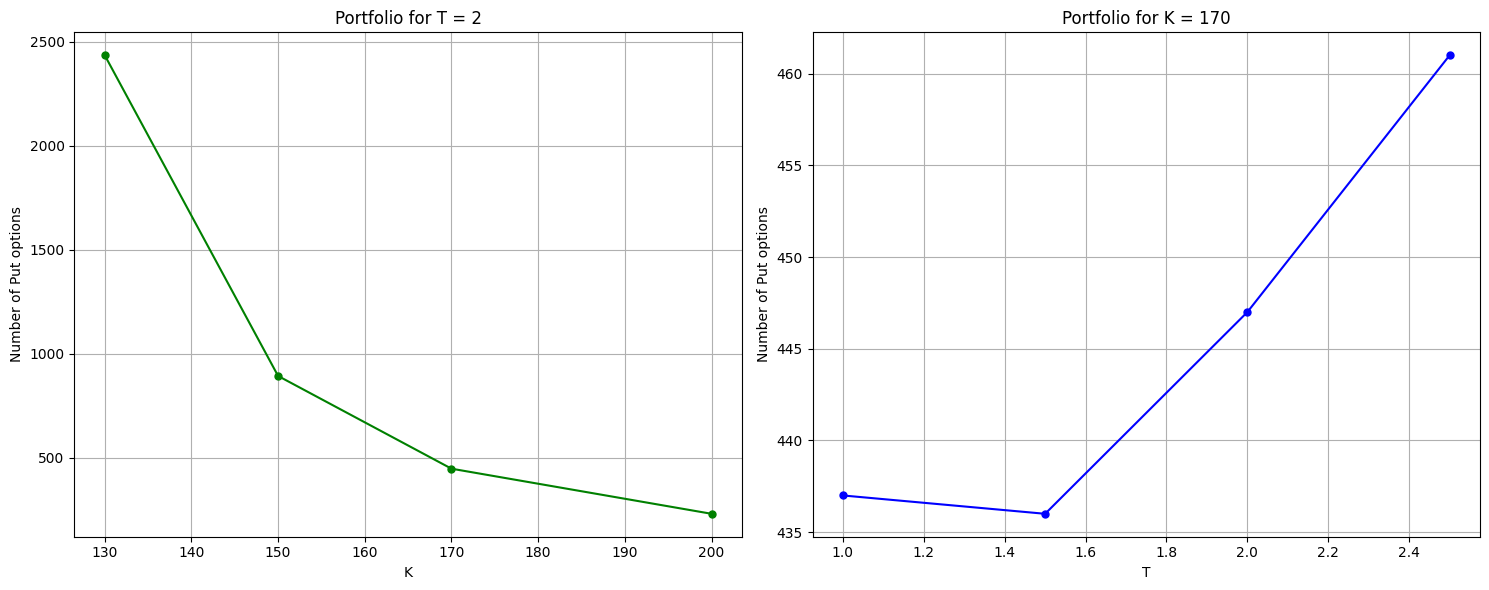

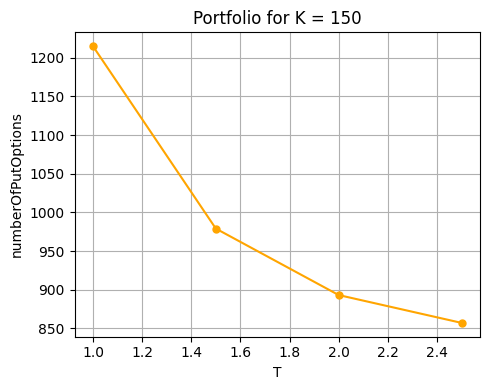

In [ ]:
# Plotting for T = 2 and K = 170 > S0 as subplots
T_, K_ = 2, 170
fig, axs = plt.subplots(1, 2, figsize = (15, 6))
df_T = df[df['T'] == T_]
df_K = df[df['K'] == K_]
axs[0].plot(df_T['K'], df_T['numberOfPutOptions'], color='g', markersize=5, marker='o')
axs[0].set_title(f'Portfolio for T = {T_}')
axs[0].set_xlabel('K')
axs[0].set_ylabel('Number of Put options')
axs[0].grid(True)

axs[1].plot(df_K['T'], df_K['numberOfPutOptions'], color='b', markersize=5, marker='o')
axs[1].set_title(f'Portfolio for K = {K_}')
axs[1].set_xlabel('T')
axs[1].set_ylabel('Number of Put options')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# For K = 150 < S0
fig = plt.figure(figsize=(5, 4))
K_ = 150
df_K = df[df['K'] == K_]
plt.plot(df_K['T'], df_K['numberOfPutOptions'], color='orange', markersize=5, marker='o')
plt.xlabel('T')
plt.ylabel('numberOfPutOptions')
plt.grid(True)
plt.title(f'Portfolio for K = {K_}')
plt.tight_layout()
plt.show()

# Implied Volatility

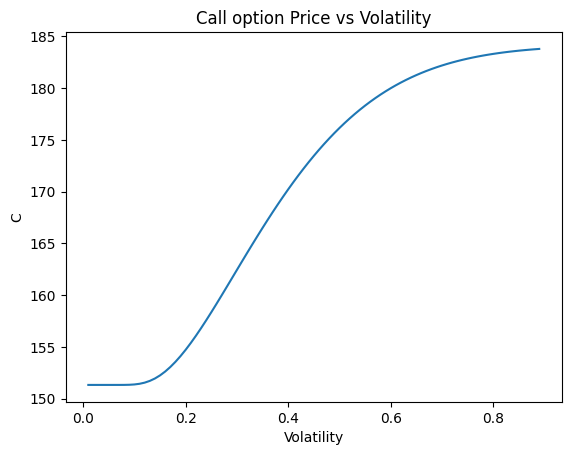

In [ ]:
# observation
sigmas = np.arange(0.01, 0.9, 0.01)
C = [option_price(s, K, r, S0, model = 'black_scholes', T = 40) for s in sigmas]

plt.plot(sigmas, C)
plt.title("Call option Price vs Volatility")
plt.xlabel("Volatility")
plt.ylabel("C")
plt.show()

In [ ]:
def newton_raphson(function, initial_guess, tolerance=1e-6, max_iterations=100, dh=1e-6):
    """
    Finds the root of a function using the Newton-Raphson method.

    Args:
    function: The function for which the root is to be found.
    initial_guess: The initial guess for the root.
    tolerance: The desired accuracy of the result (default is 1e-6).
    max_iterations: The maximum number of iterations (default is 100).
    dh: Step size for numerical differentiation (default is 1e-6).

    Returns:
    The approximated root of the function.
    """
    x = initial_guess
    for _ in range(max_iterations):
        fx = function(x)
        if abs(fx) < tolerance:
            return x
        dfx = (function(x + dh) - function(x)) / dh
        if dfx == 0:
            break
        x = x - fx / dfx
        if x < 0:
            x = dh
    return x

def implied_volatitlity(S0, K, r, T, CP, option = 'call'):
    def H(sigma):
        return (option_price(sigma = sigma, K = K, r = r, S0 = S0, model = 'black_scholes', option = option, T = T) - CP)**2

    ans = newton_raphson(H, 1.0)
    if np.abs(H(ans) - H(0.0)) < 1e-5:
        return 0.0
    return ans * 100

In [ ]:
call_volatility = []
for i in range(len(calls_df)):
    date = calls_df.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initial_price = stock_data.loc[date, 'Close']
    temp = implied_volatitlity(initial_price, calls_df.loc[i, 'strike'], r, calls_df.loc[i, 'maturity_period']/365, calls_df.loc[i, 'lastPrice'], option='call')
    # print(f"date: {date}, S0: {initial_price}, K: {calls_df.loc[i, 'strike']}, r: {r}, T: {calls_df.loc[i, 'maturity_period']}, C: {calls_df.loc[i, 'lastPrice']}, temp: {temp}%")
    call_volatility.append(temp)

put_volatility = []
for i in range(1, len(puts_df)):
    date = puts_df.loc[i, 'lastTradeDate']
    date = pd.to_datetime(date)
    date = date.strftime("%Y-%m-%d")
    initial_price = stock_data.loc[date, 'Close']
    temp = implied_volatitlity(initial_price, puts_df.loc[i, 'strike'], r, puts_df.loc[i, 'maturity_period']/365, puts_df.loc[i, 'lastPrice'], option='put')
    # print(f"date: {date}, S0: {initial_price}, K: {puts_df.loc[i, 'strike']}, r: {r}, T: {puts_df.loc[i, 'maturity_period']}, C: {puts_df.loc[i, 'lastPrice']}, temp: {temp}%")
    put_volatility.append(temp)

In [ ]:
# Create DataFrame for call options
call_data = calls_df[['strike', 'lastPrice', 'maturity_period']].copy()
call_data.rename(columns={'strike': 'K', 'lastPrice': 'C', 'maturity_period': 'T'}, inplace=True)
call_data['S0'] = [stock_data.loc[pd.to_datetime(date).strftime("%Y-%m-%d"), 'Close'] for date in calls_df['lastTradeDate']]
call_data['r'] = r
call_data['Implied Volatility(%)'] = call_volatility

tabulated_call_data = tabulate(call_data, headers='keys', tablefmt='fancy_grid')
print("Call Options:")
print(tabulated_call_data)

Call Options:
╒════╤═════╤════════╤═════╤════════╤═════════╤═════════════════════════╕
│    │   K │      C │   T │     S0 │       r │   Implied Volatility(%) │
╞════╪═════╪════════╪═════╪════════╪═════════╪═════════════════════════╡
│  0 │  30 │ 142.65 │  23 │ 173.31 │ 0.04518 │                  0      │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  1 │  55 │ 118.8  │  36 │ 173    │ 0.04518 │                  0      │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  2 │  60 │ 112.6  │  23 │ 173.31 │ 0.04518 │                  0      │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  3 │  70 │ 101.6  │  37 │ 171.13 │ 0.04518 │                122.397  │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  4 │  90 │  94.81 │  65 │ 184.15 │ 0.04518 │                  0      │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  5 │ 255 │   0.02 │  36 │ 173    │ 

In [ ]:
# Create DataFrame for put options
put_data = puts_df[['strike', 'lastPrice', 'maturity_period']].iloc[1:, :].copy()
put_data.rename(columns={'strike': 'K', 'lastPrice': 'P', 'maturity_period': 'T'}, inplace=True)
put_data['S0'] = [stock_data.loc[pd.to_datetime(date).strftime("%Y-%m-%d"), 'Close'] for date in puts_df['lastTradeDate'].iloc[1:]]
put_data['r'] = r
put_data['Implied Volatility(%)'] = put_volatility

tabulated_put_data = tabulate(put_data, headers='keys', tablefmt='fancy_grid')
print("\nPut Options:")
print(tabulated_put_data)


Put Options:
╒════╤═════╤════════╤═════╤════════╤═════════╤═════════════════════════╕
│    │   K │      P │   T │     S0 │       r │   Implied Volatility(%) │
╞════╪═════╪════════╪═════╪════════╪═════════╪═════════════════════════╡
│  1 │  70 │   0.01 │  28 │ 172.28 │ 0.04518 │                105.88   │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  2 │  75 │   0.01 │  35 │ 172.62 │ 0.04518 │                 89.2486 │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  3 │  85 │   0.02 │  45 │ 170.12 │ 0.04518 │                 70.5573 │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  4 │ 230 │  46.04 │  65 │ 184.15 │ 0.04518 │                 42.2296 │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  5 │ 240 │  50.27 │ 142 │ 189.37 │ 0.04518 │                 35.089  │
├────┼─────┼────────┼─────┼────────┼─────────┼─────────────────────────┤
│  6 │ 245 │  51.6  │  88 │ 193.89 │ 